# Model training and evaluation
---
---

## Define target y (risk_category) and features X.

In [45]:
import pandas as pd


df = pd.read_csv("../data/clustered_data.csv")

y = df["Cluster"]
X = df.drop(columns=["Cluster", "risk_category"])

## Split data (train/test with train_test_split).

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=474
)


## Handle class imbalance

In [47]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)


print("Before:", y_train.value_counts())
print("After:", y_train_res.value_counts())


Before: Cluster
1    347
0    259
Name: count, dtype: int64
After: Cluster
0    347
1    347
Name: count, dtype: int64


### Model Training & Evaluation

- **Models:** Random Forest, SVM, Logistic Regression, Decision Tree, XGBoost  
- **Metrics:** Confusion Matrix, Precision, Recall, F1-Score  
- **Validation:** 5-fold Cross-validation for robustness

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    confusion_matrix,
    recall_score,
    f1_score,
)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🔹 Model: {name}")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_mean = np.mean(cv_scores)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "CV Mean": cv_mean
    }

results_df = pd.DataFrame(results).T
print("\n✅ Final Model Comparison:\n")
print(results_df)



🔹 Model: Random Forest
Confusion Matrix:
 [[71  3]
 [ 8 70]]

🔹 Model: SVM
Confusion Matrix:
 [[70  4]
 [ 3 75]]

🔹 Model: Gradient Boosting
Confusion Matrix:
 [[71  3]
 [ 8 70]]

🔹 Model: Decision Tree
Confusion Matrix:
 [[69  5]
 [16 62]]

🔹 Model: Logistic Regression
Confusion Matrix:
 [[74  0]
 [ 0 78]]

🔹 Model: XGBoost
Confusion Matrix:
 [[72  2]
 [ 9 69]]

✅ Final Model Comparison:

                     Accuracy  Precision    Recall  F1-score   CV Mean
Random Forest        0.927632   0.929611  0.927632  0.927616  0.935317
SVM                  0.953947   0.954010  0.953947  0.953937  0.970974
Gradient Boosting    0.927632   0.929611  0.927632  0.927616  0.941957
Decision Tree        0.861842   0.870064  0.861842  0.861381  0.857494
Logistic Regression  1.000000   1.000000  1.000000  1.000000  0.993404
XGBoost              0.927632   0.931451  0.927632  0.927566  0.936659


## Perform hyperparameter tuning with GridSearchCV.

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import joblib

models_params = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=500, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.05, 0.1, 0.2],
            "subsample": [0.8, 1.0]
        }
    }
}

best_models = {}
for name, config in models_params.items():
    print(f"\n🔍 Tuning {name}...")
    
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid_search.fit(X_train_res, y_train_res)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"✅ Best Params for {name}: {grid_search.best_params_}")
    print(f"📈 Best CV Score: {grid_search.best_score_:.4f}")
    
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"🎯 Test Accuracy for {name}: {test_acc:.4f}")
    
    joblib.dump(best_model, f"../models/best_{name}_model.pkl")
    print(f"💾 Saved: best_{name}_model.joblib")

print("\n✅ All best models saved successfully!")



🔍 Tuning RandomForest...
✅ Best Params for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
📈 Best CV Score: 0.9697
🎯 Test Accuracy for RandomForest: 0.9079
💾 Saved: best_RandomForest_model.joblib

🔍 Tuning SVM...
✅ Best Params for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
📈 Best CV Score: 0.9971
🎯 Test Accuracy for SVM: 1.0000
💾 Saved: best_SVM_model.joblib

🔍 Tuning GradientBoosting...
✅ Best Params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
📈 Best CV Score: 0.9654
🎯 Test Accuracy for GradientBoosting: 0.9079
💾 Saved: best_GradientBoosting_model.joblib

🔍 Tuning DecisionTree...
✅ Best Params for DecisionTree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
📈 Best CV Score: 0.9064
🎯 Test Accuracy for DecisionTree: 0.8553
💾 Saved: best_DecisionTree_model.joblib

🔍 Tuning LogisticRegression...
✅ Best Params for LogisticRegression: {'C': 10, 'solver': 'lbfgs'}
📈 Be

c:\Users\oussa\OneDrive\Desktop\youcode_ai_projects\diabetes-risk-prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:50:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Compare models and select best.

In [50]:
model_files = {
    "Random Forest": "../models/best_RandomForest_model.pkl",
    "SVM": "../models/best_SVM_model.pkl",
    "Gradient Boosting": "../models/best_GradientBoosting_model.pkl",
    "Decision Tree": "../models/best_DecisionTree_model.pkl",
    "Logistic Regression": "../models/best_LogisticRegression_model.pkl",
    "XGBoost": "../models/best_XGBoost_model.pkl"
}

results = []

for name, path in model_files.items():
    model = joblib.load(path)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })

results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-score
1                  SVM  1.000000   1.000000  1.000000  1.000000
4  Logistic Regression  1.000000   1.000000  1.000000  1.000000
5              XGBoost  0.940789   0.940886  0.940789  0.940797
0        Random Forest  0.907895   0.910636  0.907895  0.907847
2    Gradient Boosting  0.907895   0.910636  0.907895  0.907847
3        Decision Tree  0.855263   0.857785  0.855263  0.855188


## Compare all metrics side by side

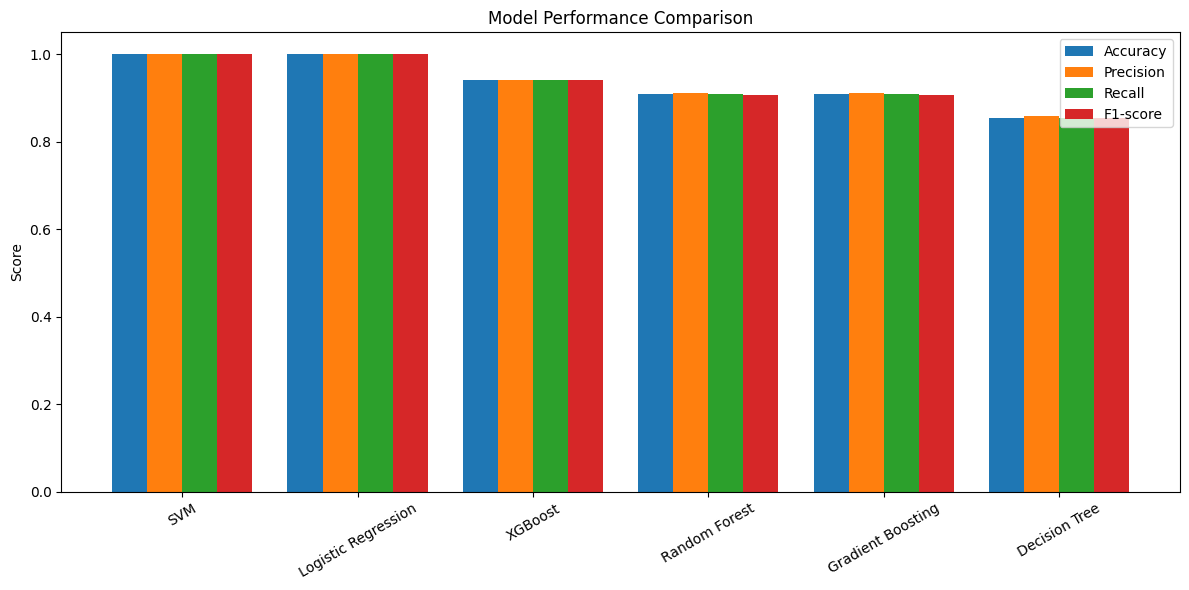

In [51]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(results_df['Model']))
width = 0.2 

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*width, results_df['Accuracy'], width, label='Accuracy')
plt.bar(x - 0.5*width, results_df['Precision'], width, label='Precision')
plt.bar(x + 0.5*width, results_df['Recall'], width, label='Recall')
plt.bar(x + 1.5*width, results_df['F1-score'], width, label='F1-score')

plt.xticks(x, results_df['Model'], rotation=30)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()